In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

import math
import tqdm

# The Metropolis-Hastings Algorithm

We build the Metropolis Adjusted Langevin dynamics algorithm.
This algorithm uses the gradient of the log of the target distribution to
guide the proposal distribution.
It's a pretty cool algorithm that shares some similarities with the NUTS (which is better but more complicated).

## Metropolis Adjusted Langevin Dynamics (MALA)

The proposal distribution of the MALA algorithm is given by

$$
q(x'|x) = \mathcal{N}\left(x' | x + \Delta t \nabla \log p(x), 2\Delta t^2 I\right),
$$

where $\Delta t$ is a step size parameter.
Recall from calculus that the gradient of a function points in the direction of steepest ascent.
So, the MALA algorithm is proposing a new state that is a random walk in the direction of steepest ascent of the log of the target distribution.
It tries to take a step in the direction of the peak of the distribution.
The gradient of the log of the target distribution is called the *score* function.
Remember the name if you dig deeper into generative models such as diffusion.

We provide a basic implementation of the MALA algorithm below.
We use `pytorch` to compute the gradient of the log of the target distribution.

In [35]:
import torch 

def mala(x0, log_h, n, dt, args=()):
    """Random walk metropolis.
    
    Arguments
    ----------
    x0     -- The initial point.
    log_h  -- The logarithm of the target distribution.
    n      -- The maximum number of steps you want to take.
    dt     -- The time step you want to use.
    args   -- Any parameters to log_h
    
    Returns
    -------
    x, acceptance_rate  -- The samples and the acceptance rate.
    """
    d = x0.shape[0]
    X = torch.zeros((n + 1, d))
    X[0, :] = x0

    x0.requires_grad_(True)
    log_h_p = log_h(x0, *args)
    log_h_p.backward()
    grad_log_h_p = x0.grad

    count_accepted = 0
    for t in tqdm.tqdm(range(1, n + 1)):
        # Proposal
        x = X[t - 1, :] + dt * x0.grad + math.sqrt(2. * dt) * torch.randn(d)
        # Calculation
        x.requires_grad_(True)
        log_h_c = log_h(x, *args)
        log_h_c.backward()
        with torch.no_grad():
            log_alpha_1 = log_h_c - log_h_p
            grad_log_h_c = x.grad
            log_T_p_to_c = -torch.sum((x - X[t - 1, :] - dt * grad_log_h_p) ** 2 / (4. * dt))
            log_T_c_to_p = -torch.sum((x + dt * grad_log_h_c - X[t - 1, :]) ** 2 / (4. * dt))
            log_alpha_2 = log_T_c_to_p - log_T_p_to_c
            log_alpha = log_alpha_1 + log_alpha_2
            alpha = min(1, torch.exp(log_alpha))
        # Accept/Reject
        u = torch.rand(1)
        if u <= alpha:
            with torch.no_grad():
                X[t, :] = x
                log_h_p = log_h_c
                grad_log_h_p = grad_log_h_c
            count_accepted += 1
        else:
            with torch.no_grad():
                X[t, :] = X[t - 1, :]
    # Empirical acceptance rate
    acceptance_rate = count_accepted / (1. * n)
    return X, acceptance_rate

## Example 1: Sampling from a Gaussian with MALA

Let's take $\mathcal{X}=\mathbb{R}^2$ and:

$$
\pi(x) \propto h(x) = \exp\left\{-\frac{1}{2}\left(x-\mu\right)^T\Lambda(x-\mu)\right\},
$$

where $\mu\in\mathbb{R}^2$ is the mean and $\Lambda = \Sigma^{-1}\in\mathbb{R}^{2\times 2}$ is the precision matrix.
We need:

$$
\log h(x) = -\frac{1}{2}(x-\mu)^T\Lambda (x-\mu),
$$

and

$$
\nabla \log h(x) = -\Lambda (x-\mu).
$$

In [40]:
def log_h_mvn(x, mu, Lambda):
    tmp = x - mu
    return -0.5 * tmp.T @ (Lambda @ tmp)


# The parameters of the distribution from which we wish to sample
mu = torch.tensor([5., 2.])
Sigma = torch.tensor([[1., .4],
                      [.3, 0.2]]) # This has to be positive definite - otherwise you will get garbage!

Lambda = torch.linalg.inv(Sigma)

# Initialiazation:
x0 = torch.randn(2)
# Parameters of the proposal:
dt = 0.1
# Number of steps:
n = 10000

# Start sampling
X, acceptance_rate = mala(x0, log_h_mvn, n, dt, args=(mu, Lambda))

print(f"Acceptance rate: {acceptance_rate:1.2f}")

100%|██████████| 10000/10000 [00:01<00:00, 6480.25it/s]

Acceptance rate: 0.91


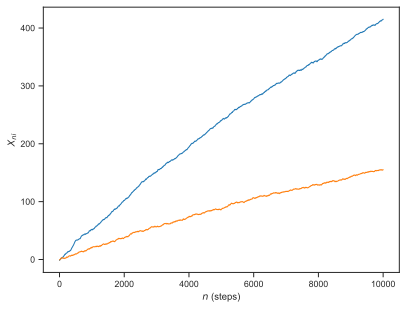

In [41]:
fig, ax = plt.subplots()
ax.plot(range(n + 1), X.detach().numpy(), lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_{ni}$');

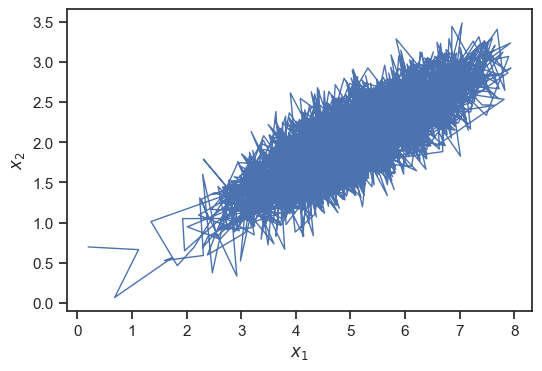

In [5]:
fig, ax = plt.subplots()
ax.plot(X[:, 0], X[:, 1], lw=1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

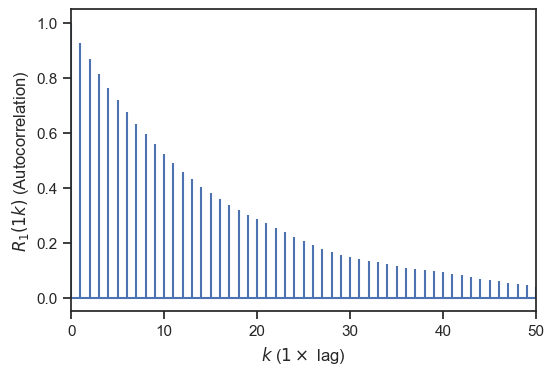

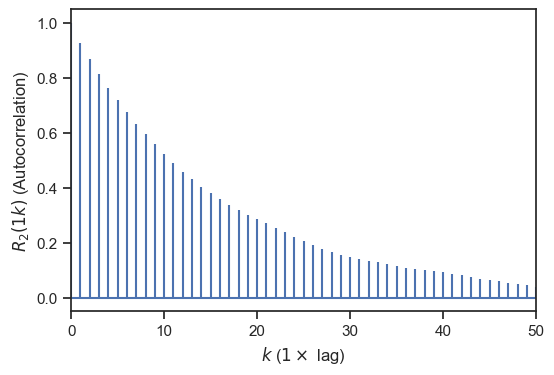

In [6]:
# How many samples do you want to burn?
burn = 500
# How many samples do you want to throw in between?
thin = 1 # Keep one every thin samples 
# Here are the remaining samples:
X_rest = X[burn::thin]
for i in range(X_rest.shape[1]):
    fig, ax = plt.subplots()
    ax.acorr(X_rest[:, 0], detrend=plt.mlab.detrend_mean, maxlags=50)
    ax.set_xlim(0, 50)
    ax.set_ylabel('$R_{%d}(%d k)$ (Autocorrelation)' % (i + 1, thin))
    ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);

### Questions

- Play with the `thin` parameter until you get a satisfactory autocorrelation plot.